In [1]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_cross_validation_metric

warnings.filterwarnings("ignore")

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
df_copy = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/train.csv')
df = df_copy.copy()
df = df.set_index('Tarih')
df.index = pd.to_datetime(df.index)

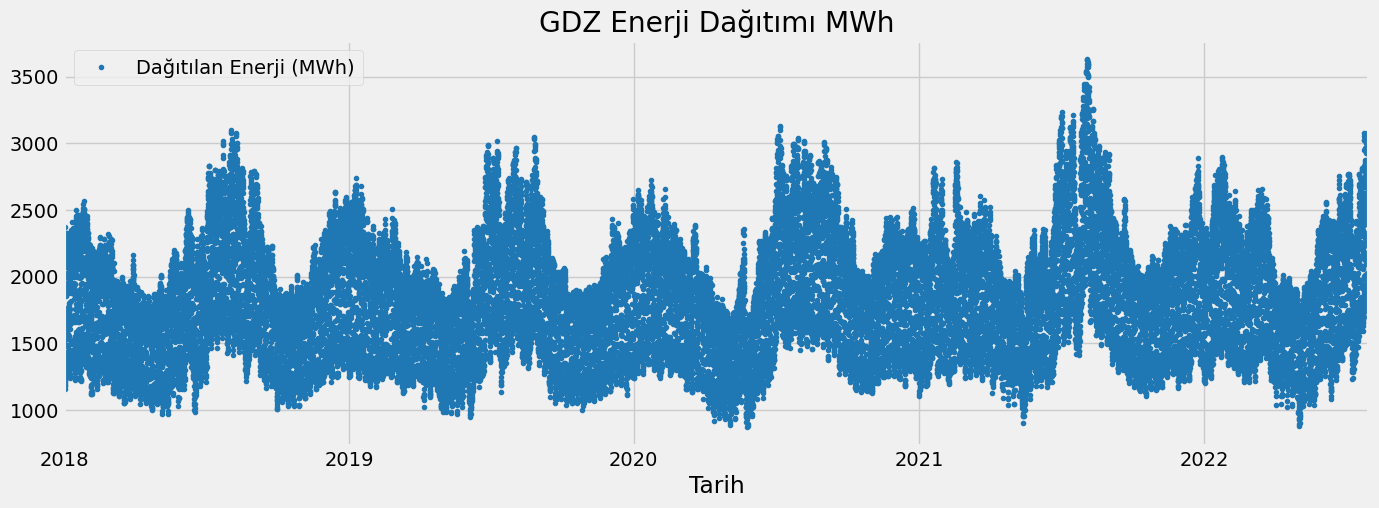

In [4]:
df.plot(style='.', 
        figsize=(15,5), 
        color=color_pal[0], 
        title='GDZ Enerji Dağıtımı MWh')
plt.show()

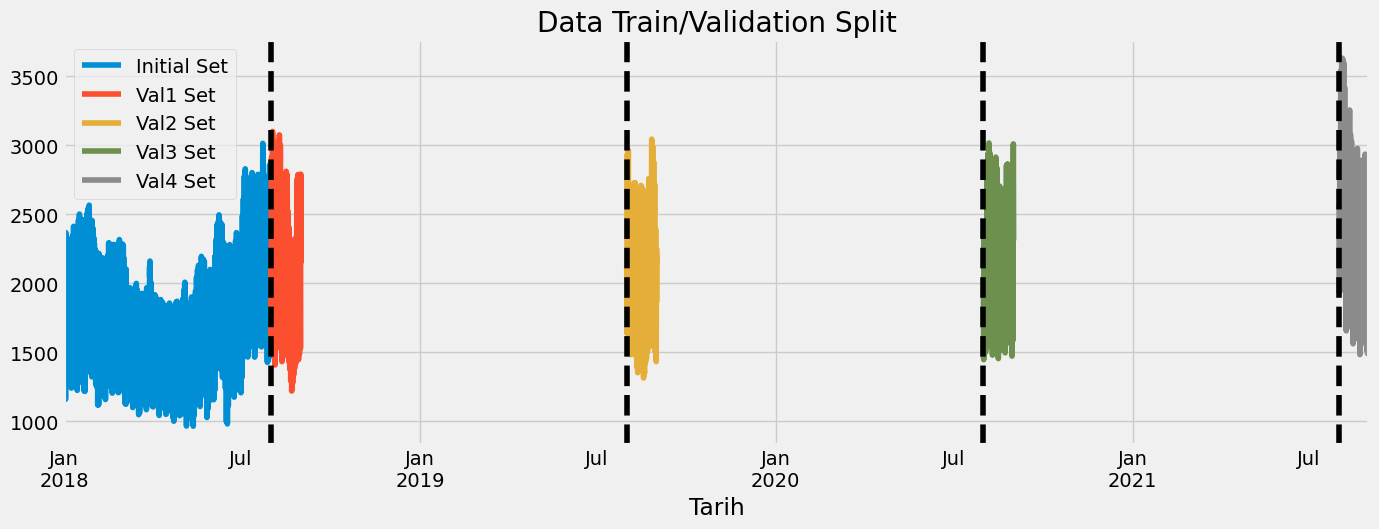

In [5]:
initial = df.loc[df.index < '2018-08-01 00:00:00']
val1 = df.loc[(df.index >= '2018-08-01 00:00:00') & (df.index < '2018-09-01 00:00:00')]
val2 = df.loc[(df.index >= '2019-08-01 00:00:00') & (df.index < '2019-09-01 00:00:00')]
val3 = df.loc[(df.index >= '2020-08-01 00:00:00') & (df.index < '2020-09-01 00:00:00')]
val4 = df.loc[(df.index >= '2021-08-01 00:00:00') & (df.index < '2021-09-01 00:00:00')]

fig, ax = plt.subplots(figsize=(15, 5))
initial.plot(ax=ax, label='Initial Set', title='Data Train/Validation Split')
val1.plot(ax=ax, label='Val1 Set')
val2.plot(ax=ax, label='Val2 Set')
val3.plot(ax=ax, label='Val3 Set')
val4.plot(ax=ax, label='Val4 Set')

ax.axvline('2018-08-01', color='black', ls='--')
ax.axvline('2019-08-01', color='black', ls='--')
ax.axvline('2020-08-01', color='black', ls='--')
ax.axvline('2021-08-01', color='black', ls='--')

ax.legend(['Initial Set', 'Val1 Set', 'Val2 Set', 'Val3 Set', 'Val4 Set'])
plt.show()

In [6]:
df = df_copy
df.rename(columns={'Tarih':'ds', 'Dağıtılan Enerji (MWh)':'y'}, inplace=True)
df_copy = df.copy()
df.head()

,ds,y
0,2018-01-01 00:00:00,1593.944216
1,2018-01-01 01:00:00,1513.933887
2,2018-01-01 02:00:00,1402.612637
3,2018-01-01 03:00:00,1278.527266
4,2018-01-01 04:00:00,1220.697701


In [7]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdown_holidays = lockdowns[['ds','holiday','lower_window','upper_window']]

In [8]:
df_med = pd.read_csv("/kaggle/input/gdz-elektrik-datathon-2023/med.csv",  parse_dates=['Tarih'])
df_med.rename(columns = {'Tarih':'ds'}, inplace = True)
df_med["holiday"] = "major_event"
df_med["lower_window"] = 0
df_med["upper_window"] = 24
holidays = pd.concat([df_med,lockdown_holidays]).reset_index(drop=True)

In [9]:
param_grid = {
    'growth': ['linear'],
    'changepoints': [None],
    'n_changepoints':[25],
    'changepoint_range':[0.8],
    'yearly_seasonality':[20],
    'weekly_seasonality':[True],
    'daily_seasonality':[True],
    'seasonality_mode': ['additive'],
    'seasonality_prior_scale': [0.01],
    'holidays_prior_scale': [10.0],
    'changepoint_prior_scale': [0.01],
    'mcmc_samples':[24],
    'interval_width':[0.8],
    'uncertainty_samples': [1000],
    'stan_backend':[None]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the MAPEs for each params here
cutoffs = pd.to_datetime(['2018-08-01', '2019-08-01', '2020-08-01', '2021-08-01'])
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(holidays=holidays, **params)  
    m.add_country_holidays(country_name='TR')
    m.fit(df) # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='744 hours', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mapes.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
print(tuning_results)

08:06:40 - cmdstanpy - INFO - CmdStan installation /opt/conda/lib/python3.7/site-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
08:06:40 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
08:06:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

08:07:03 - cmdstanpy - INFO - CmdStan done processing.
08:07:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be po

08:07:03 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 11 divergent transitions (91.7%)
	Chain 2 had 12 divergent transitions (100.0%)
	Chain 3 had 12 divergent transitions (100.0%)
	Chain 4 had 12 divergent transitions (100.0%)
	Use function "diagnose()" to see further information.
08:07:10 - cmdstanpy - INFO - CmdStan installation /opt/conda/lib/python3.7/site-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
08:07:10 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
08:07:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

08:07:25 - cmdstanpy - INFO - CmdStan installation /opt/conda/lib/python3.7/site-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
08:07:25 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
08:07:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

08:07:41 - cmdstanpy - INFO - CmdStan installation /opt/conda/lib/python3.7/site-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
08:07:41 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
08:07:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

08:07:44 - cmdstanpy - INFO - CmdStan done processing.
08:07:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, bu

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

08:08:07 - cmdstanpy - INFO - CmdStan done processing.
08:08:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, bu

08:08:09 - cmdstanpy - INFO - CmdStan done processing.
08:08:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but

08:08:34 - cmdstanpy - INFO - CmdStan done processing.
08:08:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be po

   growth changepoints  n_changepoints  changepoint_range  yearly_seasonality  \
0  linear         None              25                0.8                  20   

   weekly_seasonality  daily_seasonality seasonality_mode  \
0                True               True         additive   

   seasonality_prior_scale  holidays_prior_scale  changepoint_prior_scale  \
0                     0.01                  10.0                     0.01   

   mcmc_samples  interval_width  uncertainty_samples stan_backend      mape  
0            24             0.8                 1000         None  0.095689  


In [10]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days 03:00:00,124579.566403,352.958307,268.396356,0.103206,0.086199,0.109482,0.767677
1,3 days 04:00:00,124337.625846,352.615408,268.592237,0.103391,0.086199,0.109658,0.767677
2,3 days 05:00:00,124121.321417,352.308560,268.736008,0.103498,0.085825,0.109760,0.767677
3,3 days 06:00:00,123783.016677,351.828107,268.230891,0.103263,0.085825,0.109462,0.767677
4,3 days 07:00:00,123548.430605,351.494567,268.266929,0.103293,0.085426,0.109422,0.767677
...,...,...,...,...,...,...,...,...
665,30 days 20:00:00,41306.999711,203.241235,158.538217,0.071498,0.066457,0.073247,0.941919
666,30 days 21:00:00,41002.669293,202.491159,157.690210,0.071196,0.066457,0.072914,0.942761
667,30 days 22:00:00,40662.046215,201.648323,156.550324,0.070808,0.066346,0.072490,0.942761
668,30 days 23:00:00,40454.954342,201.134170,155.684269,0.070511,0.064789,0.072176,0.942761


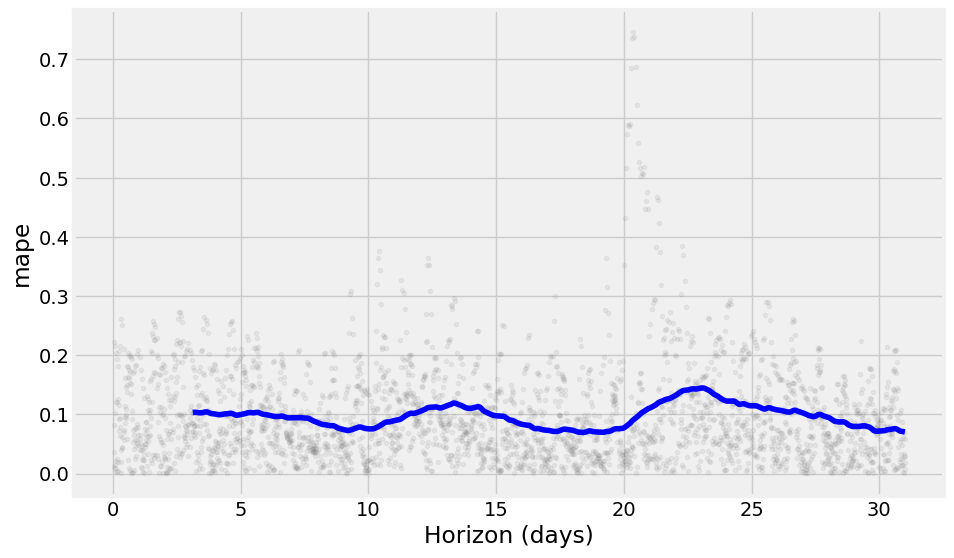

In [11]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [12]:
best_params = all_params[np.argmin(mapes)]
print(best_params)

{'growth': 'linear', 'changepoints': None, 'n_changepoints': 25, 'changepoint_range': 0.8, 'yearly_seasonality': 20, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'changepoint_prior_scale': 0.01, 'mcmc_samples': 24, 'interval_width': 0.8, 'uncertainty_samples': 1000, 'stan_backend': None}


In [13]:
m = Prophet(holidays=holidays,**best_params)  
m.add_country_holidays(country_name='TR')
m.fit(df) # Fit model with given params

08:09:02 - cmdstanpy - INFO - CmdStan installation /opt/conda/lib/python3.7/site-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
08:09:02 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
08:09:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

08:09:26 - cmdstanpy - INFO - CmdStan done processing.
08:09:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be po

08:09:26 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 12 divergent transitions (100.0%)
	Chain 2 had 11 divergent transitions (91.7%)
	Chain 3 had 12 divergent transitions (100.0%)
	Chain 4 had 5 divergent transitions (41.7%)
	Use function "diagnose()" to see further information.


In [14]:
future = m.make_future_dataframe(periods=744, freq='H')
future

,ds
0,2018-01-01 00:00:00
1,2018-01-01 01:00:00
2,2018-01-01 02:00:00
3,2018-01-01 03:00:00
4,2018-01-01 04:00:00
...,...
40891,2022-08-31 19:00:00
40892,2022-08-31 20:00:00
40893,2022-08-31 21:00:00
40894,2022-08-31 22:00:00


In [15]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
40891,2022-08-31 19:00:00,2573.865595,1924.974490,3216.351565
40892,2022-08-31 20:00:00,2576.147261,1907.379331,3214.327345
40893,2022-08-31 21:00:00,2537.980300,1860.636186,3191.398486
40894,2022-08-31 22:00:00,2439.549955,1716.763208,3128.897513
40895,2022-08-31 23:00:00,2293.373797,1628.390637,2899.779602


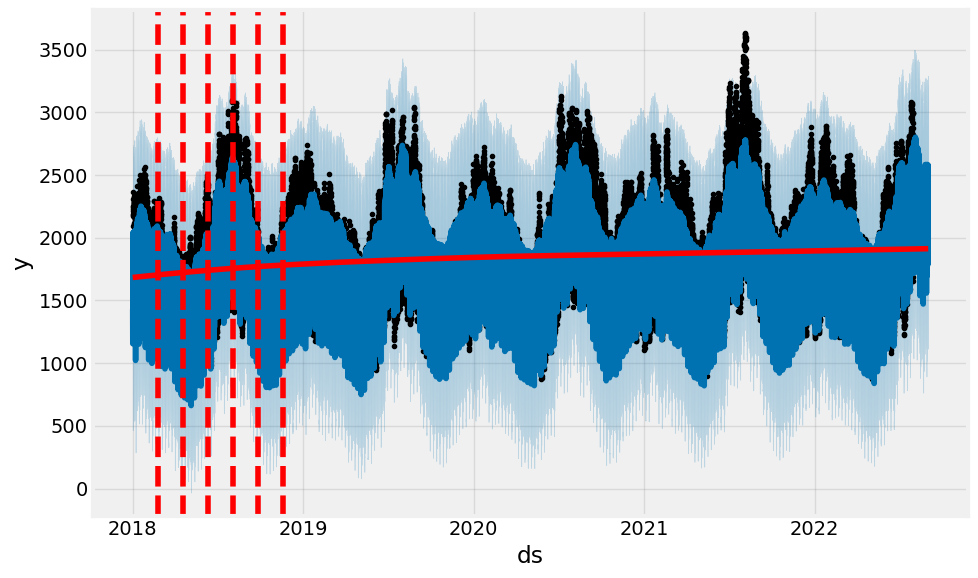

In [16]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

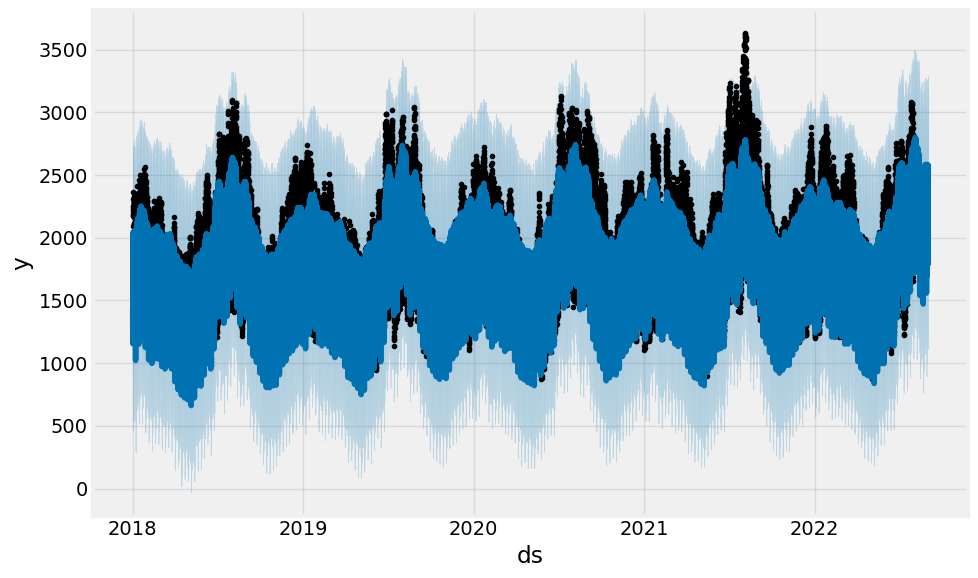

In [17]:
fig1 = m.plot(forecast)

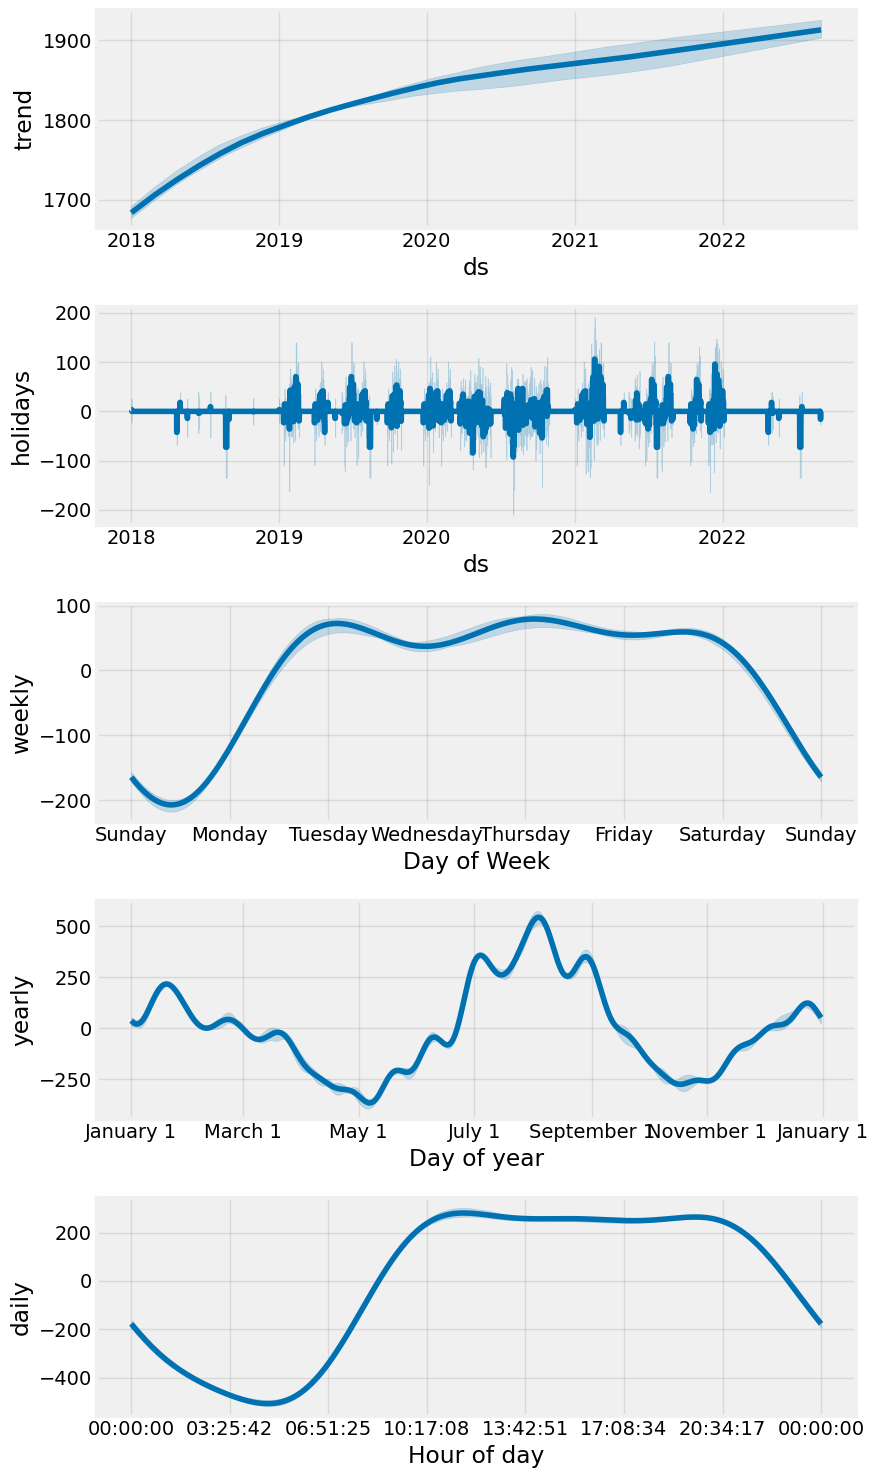

In [18]:
fig2 = m.plot_components(forecast)

In [19]:
submission_df = forecast.loc[forecast['ds'] > '2022-07-31 23:00:00',['ds','yhat']].reset_index(drop=True)
submission_df.rename(columns={'ds':'Tarih', 'yhat':'Dağıtılan Enerji (MWh)'},inplace=True)
submission_df.set_index('Tarih', inplace=True)
submission_df.to_csv('submission_prophet.csv')
submission_df

,Dağıtılan Enerji (MWh)
Tarih,
2022-08-01 00:00:00,2133.449037
2022-08-01 01:00:00,2018.212362
2022-08-01 02:00:00,1942.480886
2022-08-01 03:00:00,1893.915627
2022-08-01 04:00:00,1862.870308
...,...
2022-08-31 19:00:00,2573.865595
2022-08-31 20:00:00,2576.147261
2022-08-31 21:00:00,2537.980300


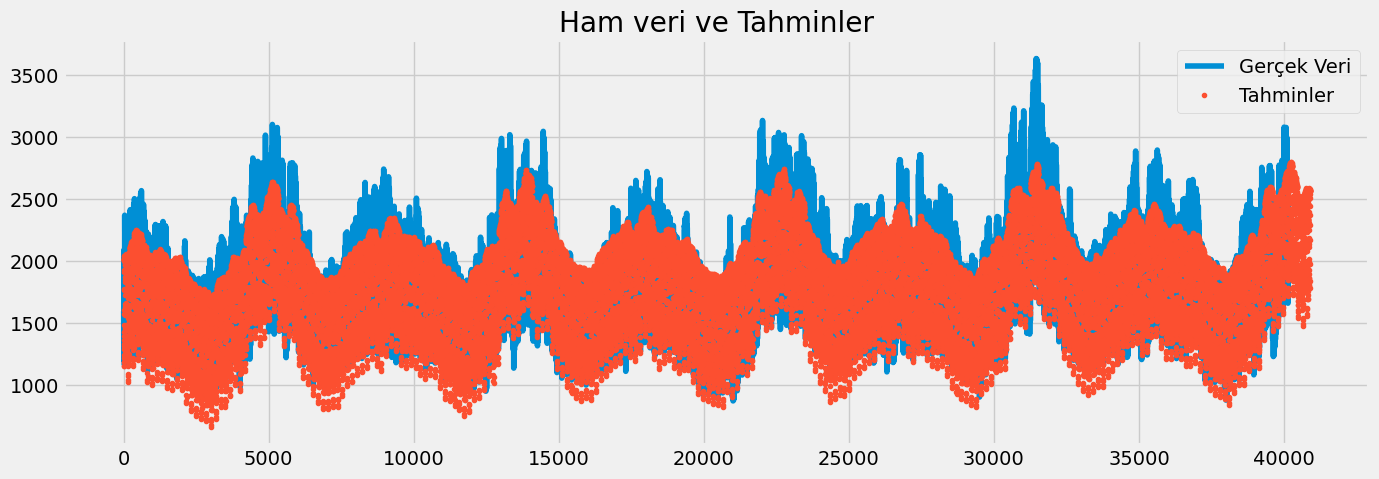

In [20]:
ax = df[['y']].plot(figsize=(15,5))
forecast['yhat'].plot(ax=ax, style='.')
plt.legend(['Gerçek Veri', 'Tahminler'])
ax.set_title('Ham veri ve Tahminler')
plt.show()

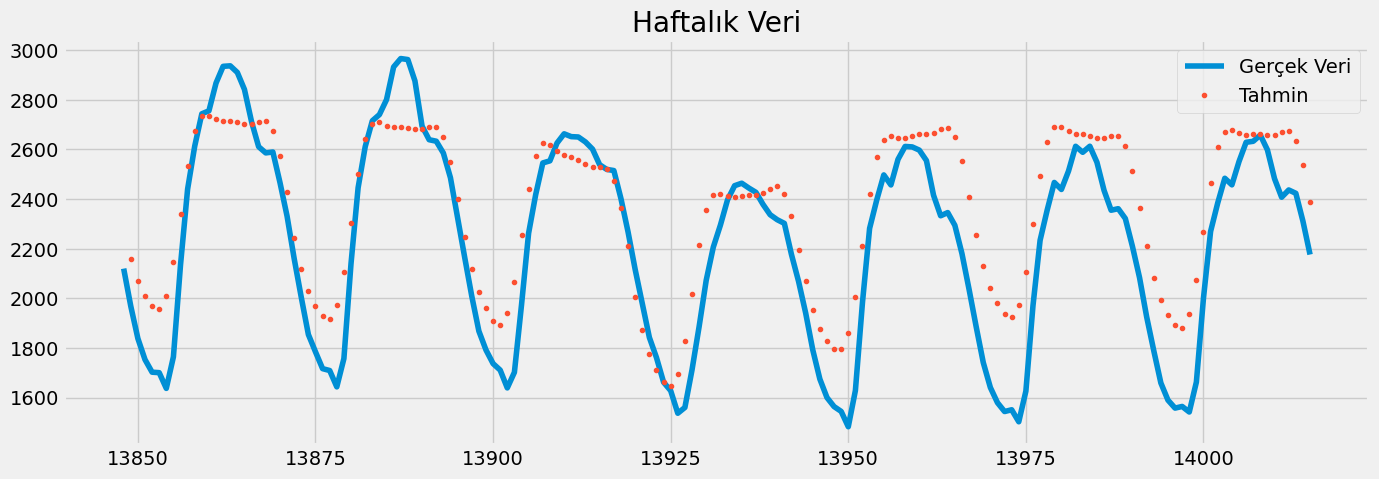

In [21]:
ax = df.loc[(df.ds > '2019-08-01') & (df.ds < '2019-08-08')]['y'].plot(figsize=(15,5), title='Haftalık Veri')
forecast.loc[(forecast.ds > '2019-08-01') & (forecast.ds < '2019-08-08')]['yhat'].plot(style='.')
plt.legend(['Gerçek Veri', 'Tahmin'])
plt.show()

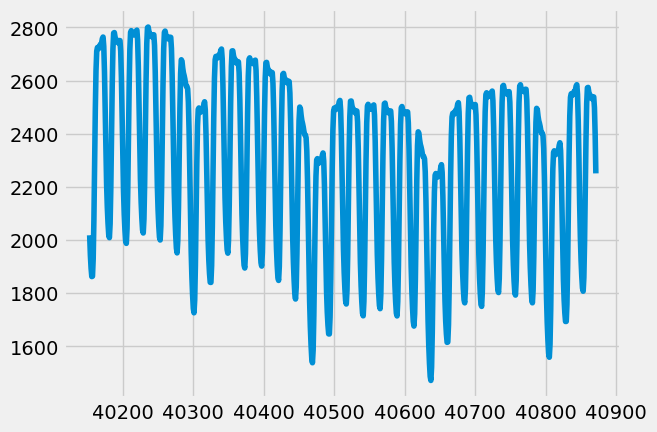

In [22]:
forecast.loc[(forecast.ds > '2022-08-01') & (forecast.ds < '2022-08-31')]['yhat'].plot()
plt.show()

In [23]:
from prophet.serialize import model_to_json, model_from_json
with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

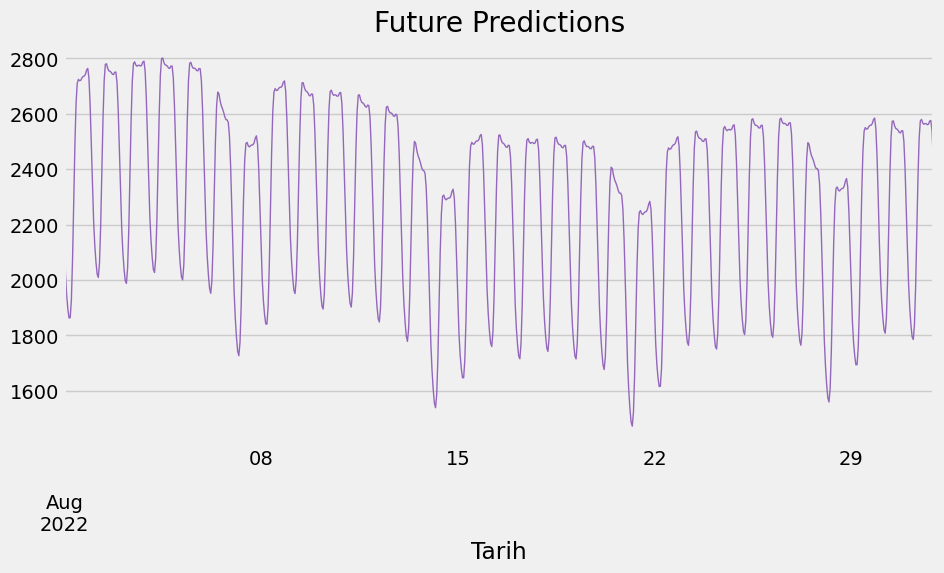

In [24]:
with open('serialized_model.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model
    
submission_df['Dağıtılan Enerji (MWh)'].plot(figsize=(10, 5), 
                       color=color_pal[4], 
                       ms=1, 
                       lw=1, 
                       title='Future Predictions')
plt.show()

## cross_validation(m, initial='942 days', period='90 days', horizon='744 hours', parallel="processes")

* MAPE is 0.105003 -> Submission MAPE is 5.45824 with Default params value without holidays

growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
    
* MAPE is 0.088538 -> Submission MAPE is 6.47687 with Default params value with holidays

{'growth': 'linear', 'changepoints': None, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 12.0, 'holidays_prior_scale': 10.0, 'changepoint_prior_scale': 0.01, 'mcmc_samples': 0, 'interval_width': 0.8, 'uncertainty_samples': 1000, 'stan_backend': None}


* MAPE is 0.077541 -> Submission is 6.04191

{'growth': 'linear', 'changepoints': None, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'changepoint_prior_scale': 0.001, 'mcmc_samples': 0, 'interval_width': 0.8, 'uncertainty_samples': 1000, 'stan_backend': None}

* MAPE is 0.094544 -> Submission MAPE is 5.47056

09:31 -> 11:09 duration is 1,5 hours

param_grid = {
    'growth': ['linear'],
    'changepoints': [None],
    'n_changepoints':[25],
    'changepoint_range':[0.8],
    'yearly_seasonality':[True],
    'weekly_seasonality':[True],
    'daily_seasonality':[True],
    'seasonality_mode': ['additive'],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [10.0],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'mcmc_samples':[0],
    'interval_width':[0.8],
    'uncertainty_samples': [1000],
    'stan_backend':[None]
}

Best params
{'growth': 'linear', 'changepoints': None, 'n_changepoints': 25, 'changepoint_range': 0.8, 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'changepoint_prior_scale': 0.01, 'mcmc_samples': 0, 'interval_width': 0.8, 'uncertainty_samples': 1000, 'stan_backend': None}

* MAPE is 0.078123 -> MAPE is Submission MAPE is 5.9096

{'growth': 'linear', 'changepoints': None, 'n_changepoints': 25, 'changepoint_range': 0.8, 'yearly_seasonality': 20, 'weekly_seasonality': 10, 'daily_seasonality': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'changepoint_prior_scale': 0.01, 'mcmc_samples': 0, 'interval_width': 0.8, 'uncertainty_samples': 1000, 'stan_backend': None}

* MAPE is 0.09062 ->

{'growth': 'linear', 'changepoints': None, 'n_changepoints': 25, 'changepoint_range': 0.8, 'yearly_seasonality': 20, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'changepoint_prior_scale': 0.01, 'mcmc_samples': 24, 'interval_width': 0.8, 'uncertainty_samples': 1000, 'stan_backend': None}